# Match test between two waveform models

In [1]:
import numpy as np
import bilby
import matplotlib.pyplot as plt
from pycbc.filter.matchedfilter import match
from pycbc.types.frequencyseries import FrequencySeries
%matplotlib inline

C = 299792458.
G = 6.67408*1e-11
Mo = 1.989*1e30
Mpc = 3.086*1e22

In [2]:
############# defining waveform arguments ################
injection_parameters = {'mass_1':36., 'mass_2':29., 'eccentricity':0.0, 'a_1':0., 'a_2':0., 'tilt_1':0.,
                         'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':600., 'theta_jn':0.4, 'psi':2.659, 
                         'phase':1.3, 'geocent_time':1246527184.169434, 'ra':1.375, 'dec':-1.2108,}

duration = 16.
reference_frequency= 10.
minimum_frequency= 10.
sampling_frequency = 2048.
waveform_arguments1 = dict(waveform_approximant='PerAdvFDLeO',
                          reference_frequency=reference_frequency, minimum_frequency=minimum_frequency)

waveform_generator1 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_PerAdvFDLeO,
    parameters=injection_parameters, waveform_arguments=waveform_arguments1)

waveform_arguments2 = dict(waveform_approximant='TaylorF2',
                          reference_frequency=reference_frequency, minimum_frequency=minimum_frequency, \
                           pn_phase_order=6, pn_amplitude_order=0.)

waveform_generator2 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_taylorF2_fd,
    parameters=injection_parameters, waveform_arguments=waveform_arguments2)

11:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_PerAdvFDLeO
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
11:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_taylorF2_fd
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [3]:
def match_calculator(waveform_generator1, waveform_arguments2, f_min=10., detector = 'L1', sampling_frequency=2048., \
                     injection_parameters={'mass_1':36., 'mass_2':29., 'eccentricity':0.0, 'a_1':0., 'a_2':0., 'tilt_1':0., \
                                           'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':600., 'theta_jn':0.4, \
                                           'psi':2.659, 'phase':1.3, 'geocent_time':1246527184.169434, 'ra':1.375, 'dec':-1.2108,}):

    '''
    Return
    match : np.array([(match_for_hplus,shift),(match_for_hcross,shift)])
    '''
    
    C = 299792458.
    G = 6.67408*1e-11
    Mo = 1.989*1e30
    m1 = injection_parameters['mass_1']
    m2 = injection_parameters['mass_2']
    mtot = m1 + m2
    f_max= (C**3)/( G*(mtot)*Mo*np.pi*6**(3/2) ) #last stable orbit frequency
    duration = int(bilby.gw.utils.calculate_time_to_merger(f_min,m1,m2)+2) # data length in time domain, will decide the frequency bin size
    
    # changing some of the parameters of waveform generator accordingly
    waveform_generator1.duration = duration
    waveform_generator1.sampling_frequency = sampling_frequency
    waveform_generator1.parameters = injection_parameters
    waveform_generator2.duration = duration
    waveform_generator2.sampling_frequency = sampling_frequency
    waveform_generator2.parameters = injection_parameters
    
    # calling the detector and its data
    ifos4 = bilby.gw.detector.InterferometerList([detector,])
    for ifo in ifos4:
        ifo.minimum_frequency = f_min
        ifo.maximum_frequency = f_max
    ifos4.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency, duration=duration,
        start_time=injection_parameters['geocent_time']-duration)
    
    # plus and cross frequency_domain_strain
    polas1 = waveform_generator1.frequency_domain_strain(parameters = injection_parameters)
    polas2 = waveform_generator2.frequency_domain_strain(parameters = injection_parameters)
    psd_ = FrequencySeries(ifos4[0].power_spectral_density_array, delta_f=1/duration)
    
    # plus polarization
    arr1 = FrequencySeries(polas1['plus'], delta_f=1/duration)
    arr2 = FrequencySeries(polas2['plus'], delta_f=1/duration)
    # cros polarization
    arr3 = FrequencySeries(polas1['cross'], delta_f=1/duration)
    arr4 = FrequencySeries(polas2['cross'], delta_f=1/duration)
    
    match_p = match(arr1, arr2, psd=psd_, low_frequency_cutoff=f_min, high_frequency_cutoff=f_max)
    match_c = match(arr3, arr4, psd=psd_, low_frequency_cutoff=f_min, high_frequency_cutoff=f_max)
    
    match_net = (match_p[0]+match_c[0])/2 # average
    
    return({'plus':match_p,'cross':match_c,'net':match_net})

### circular case

In [82]:
# for circular case
match_ = match_calculator(waveform_generator1, waveform_arguments2)
print('match = ', match_['net'])

match =  0.9999998435635388


### eccentric case 

In [83]:
# for eccentric case 
# check these : reference_frequency, minimum_frequency, f_min
############# defining waveform arguments ################
injection_parameters = {'mass_1':36., 'mass_2':29., 'eccentricity':0.1, 'a_1':0., 'a_2':0., 'tilt_1':0.,
                         'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':600., 'theta_jn':0.4, 'psi':2.659, 
                         'phase':1.3, 'geocent_time':1246527184.169434, 'ra':1.375, 'dec':-1.2108,}

duration = 16.
reference_frequency= 20.
minimum_frequency= 20.
sampling_frequency = 2048.
waveform_arguments1 = dict(waveform_approximant='PerAdvFDLeO',
                          reference_frequency=reference_frequency, minimum_frequency=minimum_frequency)

waveform_generator1 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_PerAdvFDLeO,
    parameters=injection_parameters, waveform_arguments=waveform_arguments1)

waveform_arguments2 = dict(waveform_approximant='TaylorF2',
                          reference_frequency=reference_frequency, minimum_frequency=minimum_frequency, \
                           pn_phase_order=6, pn_amplitude_order=0.)

waveform_generator2 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_taylorF2_fd,
    parameters=injection_parameters, waveform_arguments=waveform_arguments2)

match_ = match_calculator(waveform_generator1, waveform_arguments2, f_min=20., detector = 'L1', sampling_frequency=2048., \
                     injection_parameters=injection_parameters)
print('match = ', match_['net'])

08:53 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_PerAdvFDLeO
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
08:53 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_taylorF2_fd
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


match =  0.984456983928322


## TaylorF2 (3PN) Vs TaylorF2 (3.5PN)

In [22]:
# check these : reference_frequency, minimum_frequency, f_min
############# defining waveform arguments ################
# 
injection_parameters = {'mass_1':1.61, 'mass_2':1.18, 'eccentricity':0.0001, 'a_1':0., 'a_2':0., 'tilt_1':0.,
                         'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':38.87, 'theta_jn':2.52, 'psi':3.293627,
                         'phase':0., 'geocent_time':1187008882.43, 'ra':3.45, 'dec':-0.41,}

duration = 16.
reference_frequency= 20.
minimum_frequency= 20.
sampling_frequency = 2048.
waveform_arguments1 = dict(waveform_approximant='TaylorF2',
                          reference_frequency=reference_frequency, minimum_frequency=minimum_frequency, \
                           pn_phase_order=6, pn_amplitude_order=0.)

waveform_generator1 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_taylorF2_fd,
    parameters=injection_parameters, waveform_arguments=waveform_arguments1)

waveform_arguments2 = dict(waveform_approximant='TaylorF2',
                          reference_frequency=reference_frequency, minimum_frequency=minimum_frequency, \
                           pn_phase_order=7, pn_amplitude_order=0.)

waveform_generator2 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_taylorF2_fd,
    parameters=injection_parameters, waveform_arguments=waveform_arguments2)

12:03 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_taylorF2_fd
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
12:03 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_taylorF2_fd
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


### changing mass_ratio

In [23]:
match_ = match_calculator(waveform_generator1, waveform_arguments2, f_min=20., detector = 'L1', sampling_frequency=2048., \
                     injection_parameters=injection_parameters)
print('match = ', match_['net'])

match =  0.9567844264671637


In [24]:
chirp_mass_ = 1.197449
ratio = np.linspace(0.5,1,10)
match_array = []
for q in ratio:
    mass_ratio_ = q
    mass_1_ = (chirp_mass_*(1+mass_ratio_)**(1/5))/mass_ratio_**(3/5)
    mass_2_ = chirp_mass_*mass_ratio_**(2/5)*(1+mass_ratio_)**(1/5)
    injection_parameters_ = {'mass_1':mass_1_, 'mass_2':mass_2_, 'eccentricity':0.0001, 'a_1':0., 'a_2':0., 'tilt_1':0.,
                         'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':38.87, 'theta_jn':2.52, 'psi':3.293627, 
                         'phase':np.pi/4, 'geocent_time':1187008882.43, 'ra':3.45, 'dec':-0.41,}
    
    match_ = match_calculator(waveform_generator1, waveform_arguments2, f_min=20., detector = 'L1', sampling_frequency=2048., \
                     injection_parameters=injection_parameters_)
    
    match_array.append(match_['net'])

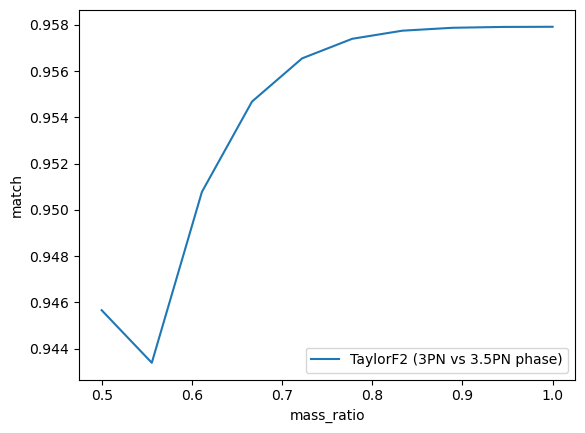

In [25]:
plt.plot(ratio,match_array) 
plt.gca().legend(('TaylorF2 (3PN vs 3.5PN phase)',))
plt.xlabel(r"mass_ratio")
plt.ylabel(r"match")
plt.show()

## PerAdvLeO Vs TaylorF2 (3PN)

In [13]:
# for eccentric case 
# check these : reference_frequency, minimum_frequency, f_min
############# defining waveform arguments ################
injection_parameters = {'mass_1':1.61, 'mass_2':1.18, 'eccentricity':0.0, 'a_1':0., 'a_2':0., 'tilt_1':0.,
                         'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':38.87, 'theta_jn':2.52, 'psi':3.293627,
                         'phase':0., 'geocent_time':1187008882.43, 'ra':3.45, 'dec':-0.41,}

duration = 16.
reference_frequency= 20.
minimum_frequency= 20.
sampling_frequency = 2048.
waveform_arguments1 = dict(waveform_approximant='PerAdvFDLeO',
                          reference_frequency=reference_frequency, minimum_frequency=minimum_frequency)

waveform_generator1 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_PerAdvFDLeO,
    parameters=injection_parameters, waveform_arguments=waveform_arguments1)

waveform_arguments2 = dict(waveform_approximant='TaylorF2',
                          reference_frequency=reference_frequency, minimum_frequency=minimum_frequency, \
                           pn_phase_order=6, pn_amplitude_order=0.)

waveform_generator2 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_taylorF2_fd,
    parameters=injection_parameters, waveform_arguments=waveform_arguments2)

11:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_PerAdvFDLeO
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
11:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_taylorF2_fd
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


### changing mass_ratio
* e0=0.0 at f_min=20Hz

In [14]:
chirp_mass_ = 1.197449
ratio = np.linspace(0.5,1,10)
match_array = []
for q in ratio:
    mass_ratio_ = q
    mass_1_ = (chirp_mass_*(1+mass_ratio_)**(1/5))/mass_ratio_**(3/5)
    mass_2_ = chirp_mass_*mass_ratio_**(2/5)*(1+mass_ratio_)**(1/5)
    injection_parameters_ = {'mass_1':mass_1_, 'mass_2':mass_2_, 'eccentricity':0.0, 'a_1':0., 'a_2':0., 'tilt_1':0.,
                         'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':38.87, 'theta_jn':2.52, 'psi':3.293627, 
                         'phase':np.pi/4, 'geocent_time':1187008882.43, 'ra':3.45, 'dec':-0.41,}
    
    match_ = match_calculator(waveform_generator1, waveform_arguments2, f_min=20., detector = 'L1', sampling_frequency=2048., \
                     injection_parameters=injection_parameters_)
    
    match_array.append(match_['net'])

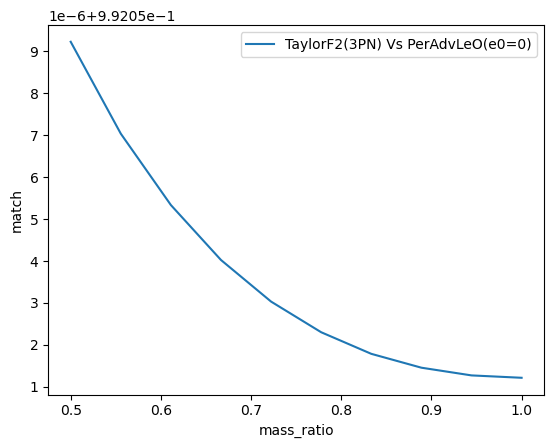

In [17]:
plt.plot(ratio,match_array) 
plt.gca().legend(('TaylorF2(3PN) Vs PerAdvLeO(e0=0)',))
plt.xlabel(r"mass_ratio")
plt.ylabel(r"match")
plt.show()

* as expected match is very close to 1

In [20]:
# e0=0.15 at f_min=20Hz
chirp_mass_ = 1.197449
ratio = np.linspace(0.5,1,10)
match_array = []
for q in ratio:
    mass_ratio_ = q
    mass_1_ = (chirp_mass_*(1+mass_ratio_)**(1/5))/mass_ratio_**(3/5)
    mass_2_ = chirp_mass_*mass_ratio_**(2/5)*(1+mass_ratio_)**(1/5)
    injection_parameters_ = {'mass_1':mass_1_, 'mass_2':mass_2_, 'eccentricity':0.1, 'a_1':0., 'a_2':0., 'tilt_1':0.,
                         'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':38.87, 'theta_jn':2.52, 'psi':3.293627, 
                         'phase':np.pi/4, 'geocent_time':1187008882.43, 'ra':3.45, 'dec':-0.41,}
    
    match_ = match_calculator(waveform_generator1, waveform_arguments2, f_min=20., detector = 'L1', sampling_frequency=2048., \
                     injection_parameters=injection_parameters_)
    
    match_array.append(match_['net'])

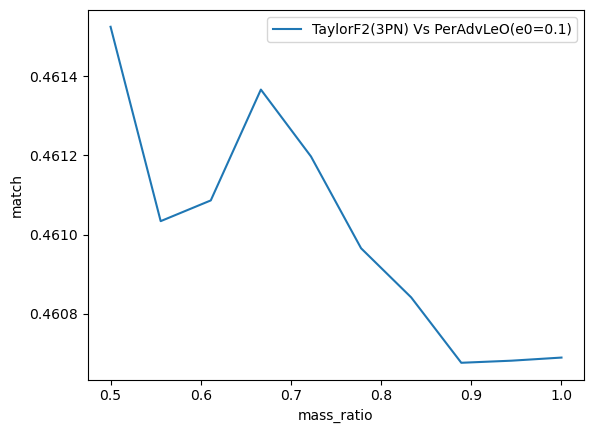

In [21]:
plt.plot(ratio,match_array) 
plt.gca().legend(('TaylorF2(3PN) Vs PerAdvLeO(e0=0.1)',))
plt.xlabel(r"mass_ratio")
plt.ylabel(r"match")
plt.show()

* match is poor if eccentricity is included